# i will deal with only image

###  DATA lINK : https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2 as cv
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [5]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [5]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

### 1.2- data cleaning

In [6]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

### 1.3- data preprocessing

In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
base_skin_dir = '../input/skin-cancer-mnist-ham10000'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [8]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 

In [9]:
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [10]:
from keras.preprocessing.image import img_to_array, array_to_img
df['image'] = df['path'].map(lambda x: img_to_array(cv.resize(cv.imread(x),(100,100),interpolation = cv.INTER_AREA)))

In [81]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

<AxesSubplot:>

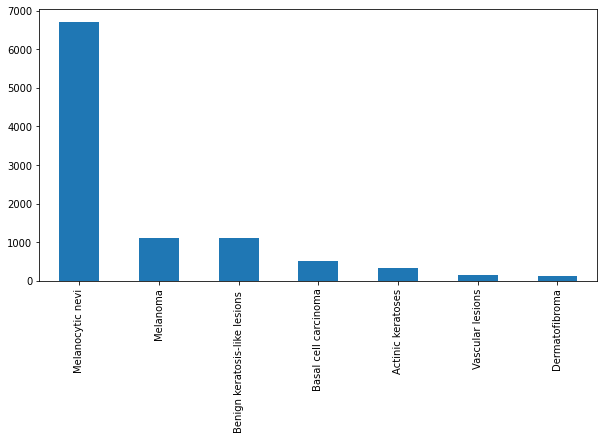

In [110]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [11]:
df2=df[["image","cell_type_idx"]]

In [12]:
X=df2["image"]
Y=df2["cell_type_idx"]

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0) 

In [14]:
x_train = np.asarray(x_train.tolist())
x_test = np.asarray(x_test.tolist())



In [15]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [16]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# VIT MODEL

In [17]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [154]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 1
image_size=100
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (100 // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier

In [155]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [156]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [157]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [158]:
def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = L.Dense(7)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


## Result 

## 

In [161]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)


In [162]:
model = vision_transformer()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])

In [166]:
epochs = 50 
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=32),
                              epochs = epochs, validation_data = (x_validate,y_validate)
                              )

Epoch 1/50
203/203 [==============================] - 30s 105ms/step - loss: 5.5241 - accuracy: 0.2325 - val_loss: 3.8588 - val_accuracy: 0.6588
Epoch 2/50
203/203 [==============================] - 20s 100ms/step - loss: 5.2781 - accuracy: 0.1506 - val_loss: 2.2857 - val_accuracy: 0.0139
Epoch 3/50
203/203 [==============================] - 20s 97ms/step - loss: 6.5832 - accuracy: 0.1478 - val_loss: 1.5506 - val_accuracy: 0.6588
Epoch 4/50
203/203 [==============================] - 20s 100ms/step - loss: 6.7736 - accuracy: 0.3168 - val_loss: 14.5167 - val_accuracy: 0.6588
Epoch 5/50
203/203 [==============================] - 20s 99ms/step - loss: 5.1393 - accuracy: 0.1595 - val_loss: 1.8651 - val_accuracy: 0.0458
Epoch 6/50
203/203 [==============================] - 20s 98ms/step - loss: 4.9123 - accuracy: 0.1086 - val_loss: 6.1287 - val_accuracy: 0.0458
Epoch 7/50
203/203 [==============================] - 20s 99ms/step - loss: 4.9294 - accuracy: 0.1842 - val_loss: 2.7249 - val_accur

# Why is the accuracy low?
due to the small size of this data

Note that the state of the art results reported in the paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

# mobile net


In [31]:
MobileNetModel = tf.keras.applications.MobileNetV2(
    input_shape=(100, 100, 3),
     include_top=False, 
     weights='imagenet',
     pooling='avg'
)
MobileNetModel.trainable = False

inputs = MobileNetModel.input

x = tf.keras.layers.Dense(512, activation='relu')(MobileNetModel.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [32]:
train_datagen = ImageDataGenerator(
                                    horizontal_flip = True,
                                  preprocessing_function =tf.keras.applications.mobilenet.preprocess_input )
model_1.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.0005), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )
x_train_gen=train_datagen.flow(x_train,y_train, batch_size=16)
val_data=train_datagen.flow(x_validate,y_validate, batch_size=16)

In [33]:
history_1 = model_1.fit(
    x_train_gen ,
    epochs=10,
    validation_data = val_data,
    batch_size=32)                              

Epoch 1/10
451/451 [==============================] - 107s 14ms/step - loss: 0.8709 - accuracy: 0.6989 - val_loss: 0.7814 - val_accuracy: 0.7257
Epoch 2/10
451/451 [==============================] - 6s 13ms/step - loss: 0.7049 - accuracy: 0.7433 - val_loss: 0.7612 - val_accuracy: 0.7282
Epoch 3/10
451/451 [==============================] - 6s 13ms/step - loss: 0.6391 - accuracy: 0.7675 - val_loss: 0.7958 - val_accuracy: 0.7257
Epoch 4/10
451/451 [==============================] - 6s 12ms/step - loss: 0.5817 - accuracy: 0.7827 - val_loss: 0.8058 - val_accuracy: 0.7182
Epoch 5/10
451/451 [==============================] - 5s 12ms/step - loss: 0.5318 - accuracy: 0.8007 - val_loss: 0.7877 - val_accuracy: 0.7369
Epoch 6/10
451/451 [==============================] - 6s 12ms/step - loss: 0.4923 - accuracy: 0.8187 - val_loss: 0.8034 - val_accuracy: 0.7332
Epoch 7/10
451/451 [==============================] - 5s 12ms/step - loss: 0.4500 - accuracy: 0.8350 - val_loss: 0.8584 - val_accuracy: 0.72